# Universal and Robust Multi-Modal Crack Extraction via Generalized Frangi Graphs and Topological Centrality

**Abstract**
Automatic crack detection is a pivotal task in structural health monitoring and geoscience. We propose a "universal", training-free approach that robustly extracts crack networks across varying data distributions. Our method generalizes the classical Frangi vesselness filter to the multi-modal setting, fusing photometric (intensity) and geometric (range/depth) data at the Hessian level. Instead of pixel-wise classification, we construct a sparse graph driven by a pairwise Frangi similarity metric. A novel topological extraction algorithm—combining HDBSCAN and Weighted Betweenness Centrality on a MST—isolates the precise topological skeleton.

This notebook reproduces the experiments presented in the paper (ICPR 2025, Lyon), illustrating the method on:
1.  **Real-world geological data**: The *Palais des Papes* in Avignon.
2.  **The FIND Benchmark**: A dataset of 500 registered intensity and range images.

---


In [1]:
# 1. Environment Setup
!pip -q install numpy scipy scikit-image matplotlib joblib tqdm tqdm-joblib hdbscan networkx gdown tifffile imageio pandas Pillow pot

import os
if not os.path.exists("Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset"):
    !git clone https://github.com/Ludwig-H/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset.git

%cd Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
!pip install -e .


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 77.6 MB/s eta 0:00:00
Cloning into 'Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset'...
remote: Enumerating objects: 656, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 656 (delta 40), reused 25 (delta 12), pack-reused 584 (from 2)
Receiving objects: 100% (656/656), 76.26 MiB | 30.95 MiB/s, done.
Resolving deltas: 100% (355/355), done.
/content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
Obtaining file:///content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for frangi-fusion (pyproject.toml) ... done
  

In [2]:
import os, sys, numpy as np, matplotlib.pyplot as plt
import gdown, imageio.v2 as iio, pandas as pd
from pathlib import Path
from scipy.io import loadmat
import h5py
from skimage import io, color, img_as_float32
from skimage.transform import resize
from skimage.morphology import binary_closing, binary_opening, disk
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from PIL import Image

# Ensure local src is importable
if os.path.exists("src"):
    sys.path.append(os.path.abspath("src"))
elif os.path.exists("Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/src"):
    sys.path.append(os.path.abspath("Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/src"))

from frangi_fusion import (
    set_seed, load_modalities_and_gt_by_index, to_gray,
    compute_hessians_per_scale, fuse_hessians_per_scale,
    build_frangi_similarity_graph, distances_from_similarity, triangle_connectivity_graph,
    largest_connected_component, hdbscan_from_sparse,
    mst_on_cluster, extract_backbone_centrality, skeleton_from_mst_graph,
    skeletonize_lee, thicken, jaccard_index, tversky_index, wasserstein_distance_skeletons,
    auto_discover_find_structure
)

# --- Global Hyper-parameters ---
Σ = [1, 3, 5, 7] #, 9]  # Gaussian scales
β = 2 # 0.5    # Frangi blob sensitivity
c = 0.25   # Contrast sensitivity
c_θ = 0.125 # Orientation sensitivity
R = 12      # Graph neighbor radius
K = 1      # 1 = Standard, 2 = Triangle Connectivity
threshold_mask = 0.6
dark_ridges = True

# expZ = 1
# min_cluster_size = 1500
# max_dist = R
# min_samples = 3
# allow_single_cluster = True

f_threshold = 0.4
min_centrality = 0.10

print("Libraries loaded and parameters defined.")


/usr/local/lib/python3.12/dist-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Libraries loaded and parameters defined.


## Methodology: Hessian Fusion and Generalized Frangi Graph

### 1. Multi-Modal Hessian Fusion
For each modality $m$ (e.g., Intensity, Depth) and scale $\sigma \in \Sigma$, we compute the normalized Hessian matrix $\hat{\mathcal{H}}_{\sigma}^{(m)}(\mathbf{x})$ at pixel $\mathbf{x}$. To handle disparate dynamic ranges, we normalize by the maximum spectral norm:
$$ \hat{\mathcal{H}}_{\sigma}^{(m)}(\mathbf{x}) = \frac{\mathcal{H}_{\sigma}^{(m)}(\mathbf{x})}{\max_{\mathbf{y} \in \Omega} \| \mathcal{H}_{\sigma}^{(m)}(\mathbf{y}) \|} $$
The **Fused Hessian** is a weighted linear combination:
$$ \mathcal{H}_{\sigma}^{\text{fused}}(\mathbf{x}) = \sum_{m} w_m \hat{\mathcal{H}}_{\sigma}^{(m)}(\mathbf{x}) $$
We analyze eigenvalues $\lambda_1, \lambda_2$ (with $|\lambda_1| \le |\lambda_2|$) and eigenvectors $\mathbf{v}_1, \mathbf{v}_2$. For cracks (dark ridges), we expect $\lambda_2 > 0$.

### 2. Generalized Frangi Similarity
We construct a graph where edges connect pixels $i, j$ within radius $R=5$. The pairwise similarity $S_{ij} ∈ [0,1]$ enforces local tubular geometry:

1.  **Elongation ($S_{\text{shape}}$):** Using ratio $\mathcal{R}_B = |\lambda_1| / |\lambda_2|$:
$$ S_{\text{shape}} = \exp\left(-\frac{1}{2} \left(\frac{\mathcal{R}_B(\mathbf{x}_i) + \mathcal{R}_B(\mathbf{x}_j)}{\beta}\right)^2\right) $$
2.  **Contrast ($S_{\text{int}}$):** Using energy $\mathcal{S} = \|\mathcal{H}\|$:
$$ S_{\text{int}} = 1 - \exp\left(-\frac{1}{2} \left(\frac{\sqrt{\mathcal{S}(\mathbf{x}_i) \cdot \mathcal{S}(\mathbf{x}_j)}}{c}\right)^2\right) $$
3.  **Alignment ($S_{\text{align}}$):** Penalizing deviation from $\mathbf{v}_1$:
$$ S_{\text{align}} = \exp\left(-\frac{1}{2} \left(\frac{\sin(\delta_\theta)}{c_\theta}\right)^2\right) $$

The final distance metric is $d_{ij} = (1 - S_{ij}) \|\mathbf{x}_i - \mathbf{x}_j\|$.

### 3. Topological Extraction
The graph is processed sequentially: **HDBSCAN Clustering**, **MST**, and **Weighted Betweenness Centrality ($C_B$)** to extract the skeleton:
$$ C_B(v) = \sum_{s ≠ v ≠ t} \frac{\eta_{st}(v)}{\eta_{st}} $$


## Part 1: Case Study - Palais des Papes (Avignon)
We demonstrate the power of fusion on a challenging real-world case: the retaining rock of the Palais des Papes.


In [3]:
# Download Avignon Data
avignon_dir = "data_avignon"
os.makedirs(avignon_dir, exist_ok=True)
ortho_id = "1OXK3XNdrirwvnwI5yZI2AKlh3qSiSeDd"
mne_id = "1iB6RllC9augWlAshqE2e08vnglHHM_PQ"
ortho_path = os.path.join(avignon_dir, "Ortho_new_extrait.tif")
mne_path = os.path.join(avignon_dir, "MNE_new_extrait.mat")

if not os.path.exists(ortho_path):
    gdown.download(id=ortho_id, output=ortho_path, quiet=False)
if not os.path.exists(mne_path):
    gdown.download(id=mne_id, output=mne_path, quiet=False)
print("Avignon data downloaded.")


Downloading...
From: https://drive.google.com/uc?id=1OXK3XNdrirwvnwI5yZI2AKlh3qSiSeDd
To: /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/data_avignon/Ortho_new_extrait.tif
100%|██████████| 1.98M/1.98M [00:00<00:00, 32.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1iB6RllC9augWlAshqE2e08vnglHHM_PQ
From (redirected): https://drive.google.com/uc?id=1iB6RllC9augWlAshqE2e08vnglHHM_PQ&confirm=t&uuid=22cffead-36a6-4679-8c2b-14e7bb7f477a
To: /content/Generalized-Frangi-for-Automatic-Crack-Extraction-on-FIND-dataset/data_avignon/MNE_new_extrait.mat
100%|██████████| 70.3M/70.3M [00:01<00:00, 67.7MB/s]

Avignon data downloaded.


Processed shapes: Image (280, 280), Depth (280, 280)


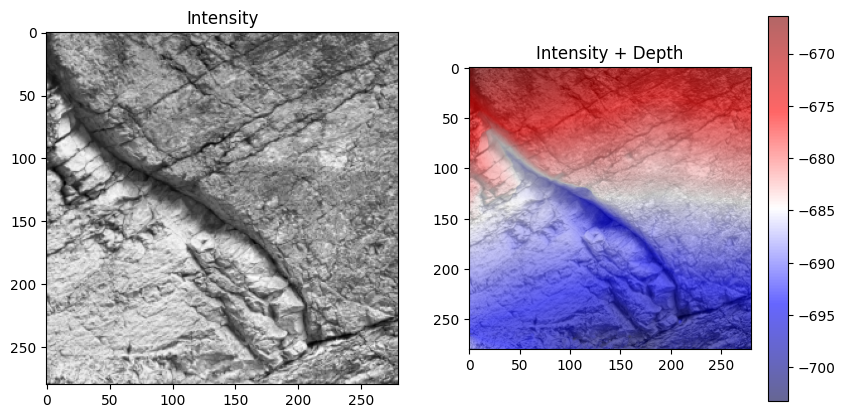

In [4]:
# Helper function to load .mat files
def load_mat_2d(path, key=None, dtype=np.float32, squeeze=True):
    path = Path(path)
    try:
        from scipy.io import loadmat
        mdict = loadmat(path)
        user_keys = [k for k in mdict.keys() if not k.startswith('__')]
        if key is None: key = user_keys[0]
        arr = mdict[key]
    except NotImplementedError:
        import h5py
        with h5py.File(path, "r") as f:
            available = list(f.keys())
            if key is None: key = available[0]
            arr = np.array(f[key])
    if squeeze: arr = np.squeeze(arr)
    return np.asarray(arr, dtype=dtype)

# Load and Preprocess
IMG_PATH = ortho_path
img = io.imread(IMG_PATH)
if img.ndim == 2: img_gray = img_as_float32(img)
else: img_gray = img_as_float32(color.rgb2gray(img))

Scale_Z = 100.0
F = 5 # Downsampling factor for speed
depth_raw = load_mat_2d(mne_path, key="mne")
depth_map = Scale_Z / F * depth_raw

# Resize
if img_gray.shape != depth_map.shape:
    depth_map = resize(depth_map, img_gray.shape, order=1, preserve_range=True)
new_shape = (img_gray.shape[0] // F, img_gray.shape[1] // F)
img_gray_small = resize(img_gray, new_shape, order=1, anti_aliasing=True, preserve_range=True)
depth_map_small = resize(depth_map, new_shape, order=1, anti_aliasing=True, preserve_range=True)

print(f"Processed shapes: Image {img_gray_small.shape}, Depth {depth_map_small.shape}")

# Visualize Inputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray_small, cmap='gray'); ax[0].set_title("Intensity")
ax[1].imshow(img_gray_small, cmap='gray')
im = ax[1].imshow(depth_map_small, cmap='seismic', alpha=0.6)
ax[1].set_title("Intensity + Depth")
plt.colorbar(im, ax=ax[1])
plt.show()


In [5]:
def run_pipeline(img_input, modality_name, custom_hessian=None):
    # 1. Hessian
    if custom_hessian is None:
        hessians = compute_hessians_per_scale(img_input, Σ)
        mods = {modality_name: hessians}
        weights = {modality_name: 1.0}
        fused_H = fuse_hessians_per_scale(mods, weights)
    else:
        fused_H = custom_hessian

    # 2. Graph
    coords, _, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, candidate_mask=None, threshold_mask=threshold_mask, dark_ridges=dark_ridges)
    D = distances_from_similarity(S, mode="minus")
    if K == 2: D = triangle_connectivity_graph(coords, D)

    # 3. Extraction
    D_cc, idx_nodes = largest_connected_component(D)
    mask = np.zeros_like(img_input)
    if D_cc.shape[0] > 0:
        Dist = D_cc.copy(); Dist.setdiag(0.0)
        # labels = hdbscan_from_sparse(Dist, min_cluster_size=min_cluster_size, allow_single_cluster=True)
        # --- MODIFICATION: SKIP HDBSCAN ---
        labels = np.zeros(D_cc.shape[0], dtype=int)
        # ----------------------------------
        sub_coords = coords[idx_nodes]
        all_edges = []
        for lab in np.unique(labels):
            if lab < 0: continue
            cl = np.where(labels == lab)[0]
            if cl.size < 3: continue
            mst = mst_on_cluster(D_cc, cl)
            global_indices = idx_nodes[cl]
            S_cluster = S[global_indices, :][:, global_indices]
            nodes_kept, skel_graph = extract_backbone_centrality(mst, f_threshold=f_threshold, S=S_cluster, take_similarity=True, min_centrality=min_centrality)
            segs = skeleton_from_mst_graph(skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True)
            if segs.shape[0] > 0: all_edges.append(segs)
        if all_edges:
            fault_edges = np.vstack(all_edges)
            for e in fault_edges:
                r0, c0, r1, c1, _ = e
                rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
                rr, cc = np.clip(rr.astype(int), 0, mask.shape[0]-1), np.clip(cc.astype(int), 0, mask.shape[1]-1)
                mask[rr, cc] = 1.0
    return fused_H, mask


Processing Intensity...
Processing Depth...
Processing Fusion...


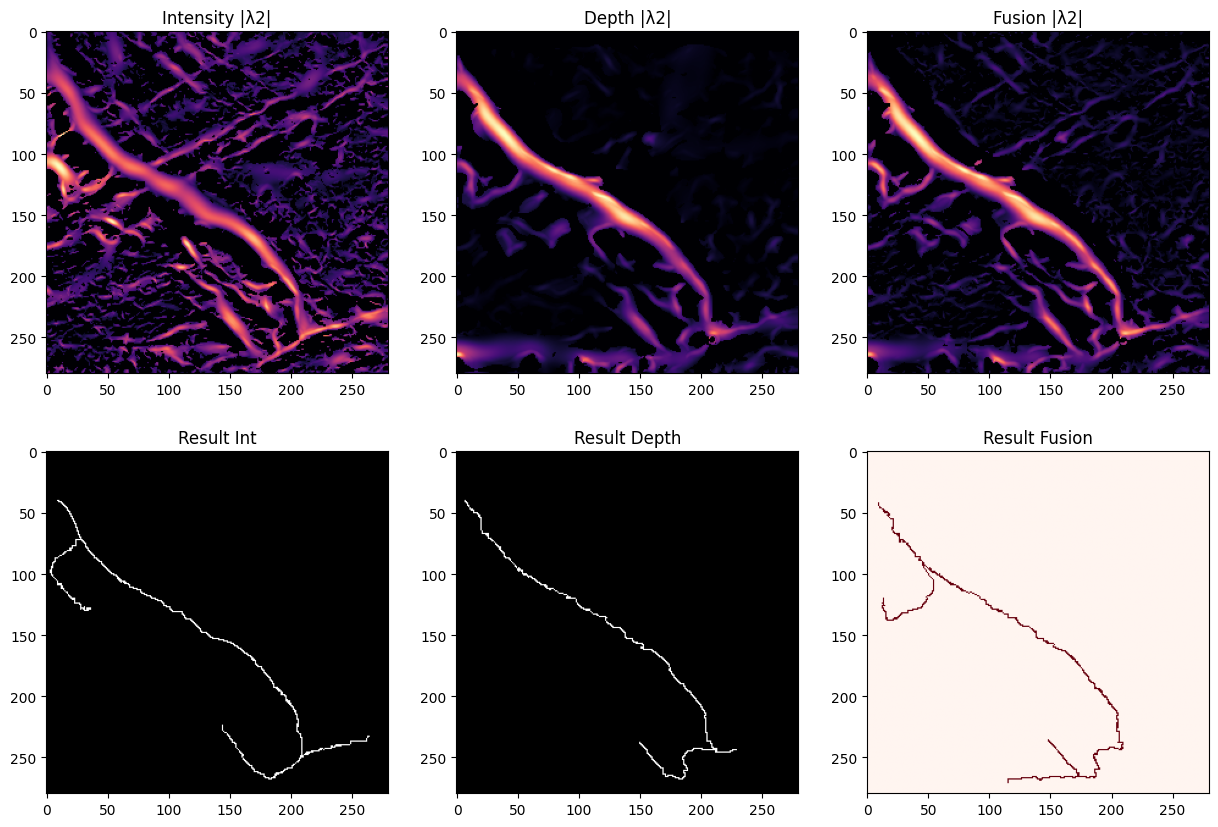

In [6]:
print("Processing Intensity...")
H_int, mask_int = run_pipeline(img_gray_small, "intensity")

print("Processing Depth...")
H_depth, mask_depth = run_pipeline(depth_map_small, "depth")

print("Processing Fusion...")
mods_fusion = {
    "intensity": compute_hessians_per_scale(img_gray_small, Σ),
    "depth": compute_hessians_per_scale(depth_map_small, Σ)
}
weights_fusion = {"intensity": 0.66, "depth": 0.33}
fused_H_final = fuse_hessians_per_scale(mods_fusion, weights_fusion)
_, mask_fusion = run_pipeline(img_gray_small, "fused", custom_hessian=fused_H_final)

# Visualize
def get_best_lambda2(hess_list):
    e2n_stack = np.stack([Hd['e2n'] for Hd in hess_list], axis=0)
    abs_e2n_stack = np.abs(e2n_stack)
    best_idx = abs_e2n_stack.argmax(axis=0)
    return np.take_along_axis(e2n_stack, best_idx[None,...], axis=0)[0]

l2_int = get_best_lambda2(H_int)
l2_depth = get_best_lambda2(H_depth)
l2_fusion = get_best_lambda2(fused_H_final)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0,0].imshow(np.clip(l2_int,0,1), cmap='magma'); axes[0,0].set_title("Intensity |λ2|")
axes[0,1].imshow(np.clip(l2_depth,0,1), cmap='magma'); axes[0,1].set_title("Depth |λ2|")
axes[0,2].imshow(np.clip(l2_fusion,0,1), cmap='magma'); axes[0,2].set_title("Fusion |λ2|")
axes[1,0].imshow(mask_int, cmap='gray'); axes[1,0].set_title("Result Int")
axes[1,1].imshow(mask_depth, cmap='gray'); axes[1,1].set_title("Result Depth")
axes[1,2].imshow(mask_fusion, cmap='Reds'); axes[1,2].set_title("Result Fusion")
plt.show()


## Part 2: FIND Dataset Benchmark


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
# Download FIND Dataset if not present
import zipfile
url = "https://drive.google.com/uc?id=1qnLMCeon7LJjT9H0ENiNF5sFs-F7-NvK"
zip_path = "data.zip"
extract_dir = "data_find"
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir, exist_ok=True)
    if not os.path.exists(zip_path):
        gdown.download(url, zip_path, quiet=False)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_dir)
    print("Unzipped FIND dataset.")
else:
    print("FIND dataset already present.")


In [ ]:
# --- Single Example Analysis (Seed=1) ---
import hdbscan

seed = 1

print(f"Analyzing image index {seed}...")
struct = auto_discover_find_structure("data_find")
dat = load_modalities_and_gt_by_index(struct, seed)
base = dat["arrays"].get("intensity", next(iter(dat["arrays"].values())))
gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)
gt = binary_closing(gt, footprint=disk(2))
gt = binary_opening(gt, footprint=disk(2))

# 1. Compute Hessians & Fusion
mods_hess = {}
weights = {"intensity": 1/2, "range": 1/2, "filtered": 0, "fused": 0.0}
valid_keys = [k for k in weights if k in dat["arrays"] and weights[k] > 0]
for k in valid_keys: mods_hess[k] = compute_hessians_per_scale(to_gray(dat["arrays"][k]), Σ)
fused_H = fuse_hessians_per_scale(mods_hess, weights)

# 2. Graph Construction
coords, _, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, candidate_mask=None, threshold_mask=threshold_mask, dark_ridges=dark_ridges)
D = distances_from_similarity(S, mode="minus")
if K == 2: D = triangle_connectivity_graph(coords, D)
D_cc, idx_nodes = largest_connected_component(D)

print(f"Largest CC: {D_cc.shape[0]} nodes.")

# 3. HDBSCAN Clustering
sub_coords = coords[idx_nodes]
if D_cc.shape[0] > 0:
    # Dist = D_cc.copy()
    # Dist.data = Dist.data ** expZ
    # Dist = Dist.tocsr()
    # Dist.setdiag(0.0)

    # Explicit HDBSCAN call as requested
    # clusterer = hdbscan.HDBSCAN(
    #     metric="precomputed",
    #     min_cluster_size=min_cluster_size,
    #     min_samples=min_samples,
    #     max_dist=max_dist,
    #     allow_single_cluster=allow_single_cluster,
    # )
    # labels = clusterer.fit_predict(Dist)
    # --- MODIFICATION: SKIP HDBSCAN ---
    labels = np.zeros(D_cc.shape[0], dtype=int)
    # ----------------------------------

    # Detailed output
    print("Clusters:", np.unique(labels), ". 'Noise':", np.sum(labels == -1))
else:
    labels = np.array([])

# 4. Skeletonization (MST + Betweenness)
all_edges = []
sk_pred_mask = np.zeros_like(base, dtype=np.uint8)
centrality_vis = np.zeros_like(base, dtype=np.float32) # VISU

if labels.size > 0:
    for lab in np.unique(labels):
        if lab < 0: continue
        cl = np.where(labels == lab)[0]
        if cl.size < 3: continue
        mst = mst_on_cluster(D_cc, cl)
        global_indices = idx_nodes[cl]
        S_cluster = S[global_indices, :][:, global_indices]

        # --- VISU CENTRALITY START ---
        # Re-compute centrality map for visualization (same logic as in mst_kcenters)
        from scipy.sparse.csgraph import breadth_first_order
        N_cl = mst.shape[0]
        order, predecessors = breadth_first_order(mst, i_start=0, directed=False, return_predecessors=True)
        node_weights = np.ones(N_cl, dtype=np.float64)
        if S_cluster is not None:
             node_weights = S_cluster.max(axis=1).toarray().flatten().astype(np.float64)
        subtree_mass = node_weights.copy()
        for i in order[::-1]:
            if i != 0:
                p = predecessors[i]
                if p>=0 and p<N_cl: subtree_mass[p] += subtree_mass[i]
        total_mass = subtree_mass[0]
        cent = subtree_mass * (total_mass - subtree_mass)
        # Normalize for display
        if cent.max() > 0: cent /= cent.max()

        # Map back to image
        rows, cols = sub_coords[cl][:, 0], sub_coords[cl][:, 1]
        centrality_vis[rows, cols] = cent
        # --- VISU CENTRALITY END ---

        nodes_kept, skel_graph = extract_backbone_centrality(mst, f_threshold=f_threshold, S=S_cluster, take_similarity=True, min_centrality=min_centrality)
        segs = skeleton_from_mst_graph(skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True)
        if segs.shape[0] > 0: all_edges.append(segs)

    if all_edges:
        fault_edges = np.vstack(all_edges)
        for e in fault_edges:
            r0, c0, r1, c1, _ = e
            rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
            rr, cc = np.clip(rr.astype(int), 0, sk_pred_mask.shape[0]-1), np.clip(cc.astype(int), 0, sk_pred_mask.shape[1]-1)
            sk_pred_mask[rr, cc] = 1

# 5. Visualizations
# Compute Best Scale features
l2_stack = np.stack([Hd['e2n'] for Hd in fused_H], axis=0)
e1_stack = np.stack([Hd['e1n'] for Hd in fused_H], axis=0)
theta_stack = np.stack([Hd['theta'] for Hd in fused_H], axis=0)

# Max over scales
best_idx = np.argmax(np.abs(l2_stack), axis=0)
H, W = l2_stack.shape[1], l2_stack.shape[2]
yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

l2_fused_vis = l2_stack[best_idx, yy, xx]
e1_fused_vis = e1_stack[best_idx, yy, xx]
theta_fused_vis = theta_stack[best_idx, yy, xx]

ratio_vis = np.abs(e1_fused_vis) / (np.abs(l2_fused_vis) + 1e-12)
ratio_vis = np.clip(ratio_vis, 0, 1) # Frangi ratio is usually in [0,1] for tubes

sim_vis = np.zeros_like(base, dtype=np.float32)
# if S.shape[0] > 0:
degs = np.array(S.max(axis=1).toarray()).flatten()
sim_vis[coords[:,0], coords[:,1]] = degs

# Prepare Metrics Visualization (Thick Skeletons)
sk_pred_thick = thicken(sk_pred_mask, pixels=3)
sk_gt_thick = thicken(skeletonize_lee(gt), pixels=3)

fig = plt.figure(figsize=(20, 25))

# Row 1: Inputs
plt.subplot(5, 4, 1); plt.title("Intensity"); plt.imshow(dat["arrays"]["intensity"], cmap="gray"); plt.axis("off")
plt.subplot(5, 4, 2); plt.title("Range"); plt.imshow(dat["arrays"]["range"], cmap="gray"); plt.axis("off")

if 'fused' in dat['arrays']:
    plt.subplot(5, 4, 3); plt.title("Fused Input"); plt.imshow(dat["arrays"]["fused"], cmap="gray"); plt.axis("off")
else:
    plt.subplot(5, 4, 3); plt.title("Fused Input (N/A)"); plt.axis("off")

if 'filtered' in dat['arrays']:
    plt.subplot(5, 4, 4); plt.title("Filtered Range"); plt.imshow(dat["arrays"]["filtered"], cmap="gray"); plt.axis("off")
else:
    plt.subplot(5, 4, 4); plt.axis("off")

# Row 2: Hessian Geometry
plt.subplot(5, 4, 5); plt.title("Frangi Ratio (|λ1|/|λ2|)"); plt.imshow(ratio_vis, cmap="viridis"); plt.axis("off")
plt.subplot(5, 4, 6); plt.title("Hessian Angle sin(θ)"); plt.imshow(np.sin(theta_fused_vis), cmap="twilight"); plt.axis("off")
plt.subplot(5, 4, 7); plt.axis("off") # Empty
plt.subplot(5, 4, 8); plt.axis("off") # Empty

# Row 3: Intermediate Features
plt.subplot(5, 4, 9); plt.title("Fused |λ2|"); plt.imshow(np.abs(l2_fused_vis), cmap="magma"); plt.axis("off")
plt.subplot(5, 4, 10); plt.title("Frangi Similarity (Max)"); plt.imshow(sim_vis, cmap="inferno"); plt.axis("off")

ax_cl = plt.subplot(5, 4, 11); ax_cl.set_title("Connected Component (No Clustering)")
ax_cl.imshow(base, cmap='gray', alpha=0.5)
if labels.size > 0:
    noise_mask = labels == -1
    cluster_mask = labels >= 0
    if np.any(noise_mask):
        ax_cl.scatter(sub_coords[noise_mask, 1], sub_coords[noise_mask, 0], c='k', s=0.5, alpha=0.3, label='Noise')
    if np.any(cluster_mask):
        ax_cl.scatter(sub_coords[cluster_mask, 1], sub_coords[cluster_mask, 0], c=labels[cluster_mask], cmap='tab20', s=1)
ax_cl.axis('off')

ax_cent = plt.subplot(5, 4, 12); ax_cent.set_title("Betweenness Centrality")
im_cent = ax_cent.imshow(centrality_vis, cmap="inferno")
# plt.colorbar(im_cent, ax=ax_cent, fraction=0.046, pad=0.04)
ax_cent.axis('off')

# Row 4: Results
plt.subplot(5, 4, 13); plt.title("Ground Truth"); plt.imshow(gt, cmap="gray"); plt.axis("off")

csd_path = f"/content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff/20000_1000/test_output_fused/im{seed+1:05d}_output_ens.png"
if os.path.exists(csd_path):
    try:
        csd_img = np.array(Image.open(csd_path).convert('L'))
        csd_bin = (csd_img > 127).astype(np.uint8)
        csd_bin = binary_closing(csd_bin, footprint=disk(2))
        csd_bin = binary_opening(csd_bin, footprint=disk(2))
        plt.subplot(5, 4, 14); plt.title("CrackSegDiff"); plt.imshow(csd_bin, cmap="Greens"); plt.axis("off")
    except Exception as e: print("Error loading CSD:", e)
else:
    plt.subplot(5, 4, 14); plt.axis("off")

ax_sk = plt.subplot(5, 4, 15); ax_sk.set_title("Ours: Skeleton Overlay")
ax_sk.imshow(base, cmap='gray')
ax_sk.imshow(sk_pred_mask, cmap='Reds', alpha=0.3, vmin=0, vmax=1)
ax_sk.axis('off')

ax_ov = plt.subplot(5, 4, 16); ax_ov.set_title("Overlay: GT(W)+Ours(R)+CSD(G)")
ax_ov.imshow(np.zeros_like(base), cmap='gray')
ax_ov.imshow(gt, cmap='Greys', alpha=0.5)
ax_ov.imshow(sk_pred_mask, cmap='Reds', alpha=0.5)
if 'csd_bin' in locals():
    ax_ov.imshow(csd_bin, cmap='Greens', alpha=0.3)
ax_ov.axis('off')

# Row 5: Metrics Visualization (Thick Skeletons)
plt.subplot(5, 4, 17); plt.title("GT Thick (Target)"); plt.imshow(sk_gt_thick, cmap="Greys"); plt.axis("off")

if 'csd_bin' in locals():
    sk_csd_thick = thicken(skeletonize_lee(csd_bin), pixels=3)
    plt.subplot(5, 4, 18); plt.title("CSD Thick (Comp)"); plt.imshow(sk_csd_thick, cmap="Greens"); plt.axis("off")
else:
    plt.subplot(5, 4, 18); plt.axis("off")

plt.subplot(5, 4, 19); plt.title("Ours Thick (Pred)"); plt.imshow(sk_pred_thick, cmap="Reds"); plt.axis("off")

ax_ov_thick = plt.subplot(5, 4, 20); ax_ov_thick.set_title("Metric Overlay")
ax_ov_thick.imshow(np.zeros_like(base), cmap='gray')
ax_ov_thick.imshow(sk_gt_thick, cmap='Greys', alpha=0.5)
ax_ov_thick.imshow(sk_pred_thick, cmap='Reds', alpha=0.5)
if 'sk_csd_thick' in locals():
    ax_ov_thick.imshow(sk_csd_thick, cmap='Greens', alpha=0.3)
ax_ov_thick.axis('off')

plt.tight_layout()
plt.show()

# Metrics for this image
print("--- Metrics (Seed 1) ---")
print("Jaccard:", jaccard_index(sk_pred_thick, sk_gt_thick))
print("Tversky:", tversky_index(sk_pred_thick, sk_gt_thick, alpha=1.0, beta=0.5))
print("Wasserstein:", wasserstein_distance_skeletons(sk_pred_thick, sk_gt_thick))

In [ ]:
# --- Batch Processing 500 Images (USE_COMBO=True) ---
import itertools

# GT not pertinent : 1, 39, 42, 152, 203, 204, 206, 397, 411, 414, 415, 431, 449, 452, 457, 460, 461, 465, 469, 471, 475, 478
# Illustration : 203 ou 206
# Question : 490 ?!?
excluded_ids = [1, 39, 42, 133, 152, 203, 204, 206, 397, 411, 414, 415, 431, 449, 452, 457, 460, 461, 465, 469, 471, 475, 478]
excluded_ids = [idx -1 for idx in excluded_ids]


start_idx = 0
end_idx = 500
n_jobs = 8
USE_COMBO = False
# allow_single_cluster = True
# --- Dynamic Output Directory based on Params ---
import hashlib
import json

# Parameters dict for logging
params_log = {
    "sigma": Σ,
    "beta": β,
    "c": c,
    "c_theta": c_θ,
    "R": R,
    "K": K,
    "threshold_mask": threshold_mask,
    "f_threshold": f_threshold,
    "min_centrality": min_centrality,
    "weights": weights,
    "dark_ridges": dark_ridges
}

# Generate descriptive name
# Simplify weights string
w_str = "-".join([f"{k[0]}{v:.2f}" for k,v in weights.items()])
run_name = f"Batch_beta{β}_R{R}_w{w_str}"

base_output_dir = "/content/drive/MyDrive/Datasets/FIND/Results/Avignon_Notebook_Batch"
output_dir = os.path.join(base_output_dir, run_name)
os.makedirs(output_dir, exist_ok=True)

# Save params
with open(os.path.join(output_dir, "params.json"), "w") as f:
    json.dump(params_log, f, indent=4)
# -----------------------------------------------
os.makedirs(output_dir, exist_ok=True)
print(f"Results will be saved to: {output_dir}")

def process_image_idx_combo(idx):
    if idx in excluded_ids: return None
    try:
        dat = load_modalities_and_gt_by_index(struct, idx)
        base = dat["arrays"].get("intensity", next(iter(dat["arrays"].values())))
        gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)
        gt = binary_closing(gt, footprint=disk(2))
        gt = binary_opening(gt, footprint=disk(2))
        sk_gt_thick = thicken(skeletonize_lee(gt), pixels=3)

        # --- Load CSD & Compute Metrics ---
        csd_path_in = f"/content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff/20000_1000/test_output_fused/im{idx+1:05d}_output_ens.png"
        sk_csd_thick = np.zeros_like(sk_gt_thick)
        csd_jac, csd_tvs, csd_wass = 0.0, 0.0, 0.0
        if os.path.exists(csd_path_in):
            try:
                csd_img = np.array(Image.open(csd_path_in).convert('L'))
                csd_bin = (csd_img > 127).astype(np.uint8)
                csd_bin = binary_closing(csd_bin, footprint=disk(2))
                csd_bin = binary_opening(csd_bin, footprint=disk(2))
                sk_csd_thick = thicken(skeletonize_lee(csd_bin), pixels=3)

                csd_jac = jaccard_index(sk_csd_thick, sk_gt_thick)
                csd_tvs = tversky_index(sk_csd_thick, sk_gt_thick, alpha=1.0, beta=0.5)
                csd_wass = wasserstein_distance_skeletons(sk_csd_thick, sk_gt_thick)
            except: pass
        # ----------------------------------

        # Pre-compute Hessians (Normal & Inverted)
        hessian_cache = {}
        valid_keys = [k for k in weights if k in dat["arrays"] and weights[k] > 0]
        for k in valid_keys:
            arr = to_gray(dat["arrays"][k])
            h_norm = compute_hessians_per_scale(arr, Σ)
            hessian_cache[k] = [h_norm]
            if USE_COMBO:
                h_inv = compute_hessians_per_scale(255 - arr, Σ)
                hessian_cache[k].append(h_inv)

        # Combinations
        combo_indices = list(itertools.product([0, 1], repeat=len(valid_keys))) if USE_COMBO else [tuple(0 for _ in valid_keys)]

        best_tversky = -1.0
        best_res = None

        for combo in combo_indices:
            current_mods = {}
            for i, mod in enumerate(valid_keys):
                current_mods[mod] = hessian_cache[mod][combo[i]]

            fused_H = fuse_hessians_per_scale(current_mods, weights)
            coords, _, S = build_frangi_similarity_graph(fused_H, β, c, c_θ, R, candidate_mask=None, threshold_mask=threshold_mask, dark_ridges=dark_ridges)
            D = distances_from_similarity(S, mode="minus")
            if K == 2: D = triangle_connectivity_graph(coords, D)
            D_cc, idx_nodes = largest_connected_component(D)

            sk_pred = np.zeros_like(base, dtype=np.uint8)
            if D_cc.shape[0] > 0:
                # expZ = 1
                # Dist = D_cc.copy()
                # Dist.data = Dist.data ** expZ
                # Dist = Dist.tocsr()
                # Dist.setdiag(0.0)

                # Explicit HDBSCAN call
                # clusterer = hdbscan.HDBSCAN(
                #     metric="precomputed",
                #     min_cluster_size=min_cluster_size,
                #     min_samples=min_samples,
                #     max_dist=max_dist,
                #     allow_single_cluster=allow_single_cluster,
                # )
                # labels = clusterer.fit_predict(Dist)
                # --- MODIFICATION: SKIP HDBSCAN ---
                labels = np.zeros(D_cc.shape[0], dtype=int)
                # ----------------------------------

                sub_coords = coords[idx_nodes]
                all_edges = []
                for lab in np.unique(labels):
                    if lab < 0: continue
                    cl = np.where(labels == lab)[0]
                    if cl.size < 3: continue
                    mst = mst_on_cluster(D_cc, cl)
                    global_indices = idx_nodes[cl]
                    S_cluster = S[global_indices, :][:, global_indices]
                    nodes_kept, skel_graph = extract_backbone_centrality(mst, f_threshold=f_threshold, S=S_cluster, take_similarity=True, min_centrality=min_centrality)
                    segs = skeleton_from_mst_graph(skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True)
                    if segs.shape[0] > 0: all_edges.append(segs)
                if all_edges:
                    fault_edges = np.vstack(all_edges)
                    mask = np.zeros_like(base, dtype=np.uint8)
                    for e in fault_edges:
                        r0, c0, r1, c1, _ = e
                        rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
                        rr, cc = np.clip(rr.astype(int), 0, mask.shape[0]-1), np.clip(cc.astype(int), 0, mask.shape[1]-1)
                        mask[rr, cc] = 1
                    sk_pred = skeletonize_lee(mask)

            sk_pred_thick = thicken(sk_pred, pixels=3)
            tvs = tversky_index(sk_pred_thick, sk_gt_thick, alpha=1.0, beta=0.5)

            if tvs > best_tversky:
                best_tversky = tvs
                jac = jaccard_index(sk_pred_thick, sk_gt_thick)
                wass = wasserstein_distance_skeletons(sk_pred_thick, sk_gt_thick)

                # --- SAVE VISUALIZATIONS ---
                skel_dir = os.path.join(output_dir, "skeleton")
                over_dir = os.path.join(output_dir, "overlay")
                os.makedirs(skel_dir, exist_ok=True)
                os.makedirs(over_dir, exist_ok=True)

                # 1. Skeleton Image (Ours Thick)
                skel_path = os.path.join(skel_dir, f"im{idx+1:05d}_skel.png")
                # Ensure binary is 0-255
                iio.imwrite(skel_path, (sk_pred_thick * 255).astype(np.uint8))

                # 2. Metric Overlay (GT=White, Ours=Red, CSD=Green)
                csd_path_in = f"/content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff/20000_1000/test_output_fused/im{idx+1:05d}_output_ens.png"
                sk_csd_thick = np.zeros_like(sk_gt_thick)
                if os.path.exists(csd_path_in):
                    try:
                        csd_img = np.array(Image.open(csd_path_in).convert('L'))
                        csd_bin = (csd_img > 127).astype(np.uint8)
                        csd_bin = binary_closing(csd_bin, footprint=disk(2))
                        csd_bin = binary_opening(csd_bin, footprint=disk(2))
                        sk_csd_thick = thicken(skeletonize_lee(csd_bin), pixels=3)
                    except: pass

                # RGB Overlay
                H_ov, W_ov = sk_gt_thick.shape
                ov_img = np.zeros((H_ov, W_ov, 3), dtype=np.uint8)
                ov_img[..., 0] = np.clip(sk_gt_thick * 255 + sk_pred_thick * 255, 0, 255) # R
                ov_img[..., 1] = np.clip(sk_gt_thick * 255 + sk_csd_thick * 255, 0, 255)  # G
                ov_img[..., 2] = np.clip(sk_gt_thick * 255, 0, 255)                       # B

                over_path = os.path.join(over_dir, f"im{idx+1:05d}_overlay.png")
                iio.imwrite(over_path, ov_img)
                # ---------------------------

                best_res = {
                    "Image": f"im{idx+1:05d}",
                    "Jaccard": jac,
                    "Tversky": tvs,
                    "Wasserstein": wass,
                    "CSD_Jaccard": csd_jac,
                    "CSD_Tversky": csd_tvs,
                    "CSD_Wasserstein": csd_wass,

                    "Combo": str(combo)
                }
        return best_res
    except Exception as e: return None

print(f"Processing batch {start_idx}-{end_idx}...")
with tqdm_joblib(tqdm(total=end_idx-start_idx)) as progress_bar:
    results = Parallel(n_jobs=n_jobs)(delayed(process_image_idx_combo)(i) for i in range(start_idx, end_idx))

results = [r for r in results if r is not None]
df_res = pd.DataFrame(results)
if not df_res.empty:
    print("\n--- Results ---")

    # Append mean row
    numeric_cols = ["Jaccard", "Tversky", "Wasserstein", "CSD_Jaccard", "CSD_Tversky", "CSD_Wasserstein"]
    mean_vals = df_res[numeric_cols].mean()
    print("--- Mean Results ---")
    print(mean_vals)

    mean_row = mean_vals.to_dict()
    mean_row["Image"] = "MEAN"
    mean_row["Combo"] = "N/A"

    df_final = pd.concat([df_res, pd.DataFrame([mean_row])], ignore_index=True)
    df_final.to_csv(os.path.join(output_dir, "metrics_combo.csv"), index=False)

else: print("No valid results.")


# Noisy images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Bruit reproductible même en parallèle
NOISE_BASE_SEED = 1

def _normalize01(x: np.ndarray):
    x = np.asarray(x).astype(np.float32)
    mn = float(np.min(x))
    mx = float(np.max(x))
    if (mx - mn) < 1e-12:
        return np.zeros_like(x, dtype=np.float32), mn, mx
    return (x - mn) / (mx - mn), mn, mx

def _denormalize01(x01: np.ndarray, mn: float, mx: float):
    return x01 * (mx - mn) + mn

def add_speckle_intensity(x: np.ndarray, var: float, rng: np.random.Generator):
    """Speckle: y = x + x*n, n~N(0,var) appliqué sur x normalisé [0,1]."""
    if var <= 0:
        return np.asarray(x).astype(np.float32)
    x01, mn, mx = _normalize01(x)
    n = rng.normal(0.0, np.sqrt(var), size=x01.shape).astype(np.float32)
    y01 = x01 + x01 * n
    y01 = np.clip(y01, 0.0, 1.0)
    return _denormalize01(y01, mn, mx).astype(np.float32)

def add_gaussian_range(x: np.ndarray, sigma: float, rng: np.random.Generator):
    """Bruit gaussien additif sur x normalisé [0,1]."""
    if sigma <= 0:
        return np.asarray(x).astype(np.float32)
    x01, mn, mx = _normalize01(x)
    y01 = x01 + rng.normal(0.0, sigma, size=x01.shape).astype(np.float32)
    y01 = np.clip(y01, 0.0, 1.0)
    return _denormalize01(y01, mn, mx).astype(np.float32)

def make_noisy_arrays(arrays: dict, idx: int, level_id: int,
                      speckle_var: float = 0.0, range_sigma: float = 0.0,
                      noise_filtered_like_range: bool = True):
    """
    Reprend dat["arrays"] et renvoie une copie avec bruit:
      - intensity : speckle(var)
      - range     : gaussian(sigma)
      - filtered  : (option) gaussian(sigma) aussi, sinon tu donnes une modalité range "clean" cachée.
    """
    out = dict(arrays)

    # Seeds déterministes (idx, level_id) -> reproductible
    rng_I = np.random.default_rng(NOISE_BASE_SEED + 100000 * idx + 97 * level_id + 1)
    rng_R = np.random.default_rng(NOISE_BASE_SEED + 100000 * idx + 97 * level_id + 2)

    if "intensity" in out and speckle_var > 0:
        out["intensity"] = add_speckle_intensity(out["intensity"], speckle_var, rng_I)

    if "range" in out and range_sigma > 0:
        out["range"] = add_gaussian_range(out["range"], range_sigma, rng_R)

    if noise_filtered_like_range and ("filtered" in out) and range_sigma > 0:
        # même RNG_R pour cohérence (range/filtered)
        out["filtered"] = add_gaussian_range(out["filtered"], range_sigma, rng_R)

    return out

def show_noisy_modalities_seed(struct, seed_idx: int,
                               speckle_vars=(0.0, 0.005, 0.02, 0.08),
                               range_sigmas=(0.0, 0.01, 0.05, 0.12),
                               noise_filtered_like_range=True):
    dat = load_modalities_and_gt_by_index(struct, seed_idx)

    if "intensity" not in dat["arrays"] or "range" not in dat["arrays"]:
        raise ValueError("Il manque 'intensity' et/ou 'range' dans dat['arrays'].")

    ncols = max(len(speckle_vars), len(range_sigmas))
    fig, axes = plt.subplots(2, ncols, figsize=(4*ncols, 7))

    for j in range(ncols):
        axes[0, j].axis("off")
        axes[1, j].axis("off")

    # Intensity speckle
    for j, var in enumerate(speckle_vars):
        noisy = make_noisy_arrays(dat["arrays"], seed_idx, j,
                                  speckle_var=float(var), range_sigma=0.0,
                                  noise_filtered_like_range=noise_filtered_like_range)
        axes[0, j].imshow(to_gray(noisy["intensity"]), cmap="gray")
        axes[0, j].set_title(f"Intensity speckle var={var}")

    # Range gaussian
    for j, sig in enumerate(range_sigmas):
        noisy = make_noisy_arrays(dat["arrays"], seed_idx, j,
                                  speckle_var=0.0, range_sigma=float(sig),
                                  noise_filtered_like_range=noise_filtered_like_range)
        axes[1, j].imshow(to_gray(noisy["range"]), cmap="gray")
        axes[1, j].set_title(f"Range gauss σ={sig}")

    plt.tight_layout()
    plt.show()

# Exemple (prend ton 'seed' existant si défini)
# show_noisy_modalities_seed(struct, seed_idx=seed)


In [ ]:
import itertools
import numpy as np

THICK_PIXELS = 3
TV_ALPHA = 1.0
TV_BETA  = 0.5

def frangi_predict_mask_from_arrays(arrays: dict,
                                    weights: dict,
                                    use_combo: bool = False,
                                    combo: tuple = None,
                                    gt_thick: np.ndarray = None):
    """
    Reprend ton pipeline batch:
      - Hessians par modalité (+ inversé si use_combo)
      - Fusion
      - build_frangi_similarity_graph
      - distances + LCC
      - SKIP HDBSCAN (labels=0)
      - MST + backbone centrality + segments -> mask

    Si combo est fourni: l'applique directement.
    Si combo est None et use_combo=True et gt_thick fourni:
        sélectionne le meilleur combo via Tversky sur sk_thick (comme ton batch "best_tversky").
    """
    base = arrays.get("intensity", next(iter(arrays.values())))
    base = np.asarray(base)

    valid_keys = [k for k in weights if (k in arrays and weights[k] > 0)]
    if len(valid_keys) == 0:
        raise ValueError("Aucune modalité valide: vérifie weights vs arrays.")

    # --- Cache Hessians (normal + inversé) ---
    hessian_cache = {}
    for k in valid_keys:
        arr = to_gray(arrays[k])
        h_norm = compute_hessians_per_scale(arr, Σ)
        hessian_cache[k] = [h_norm]
        if use_combo:
            h_inv = compute_hessians_per_scale(255 - arr, Σ)
            hessian_cache[k].append(h_inv)

    # combos
    if use_combo:
        combo_list = [combo] if combo is not None else list(itertools.product([0, 1], repeat=len(valid_keys)))
    else:
        combo_list = [tuple(0 for _ in valid_keys)]

    best_tversky = -1.0
    best_combo = combo_list[0]
    best_mask = np.zeros_like(base, dtype=np.uint8)

    for cmb in combo_list:
        # 1) Fusion
        current_mods = {}
        for i, mod in enumerate(valid_keys):
            current_mods[mod] = hessian_cache[mod][cmb[i]]
        fused_H = fuse_hessians_per_scale(current_mods, weights)

        # 2) Graph
        coords, _, S = build_frangi_similarity_graph(
            fused_H, β, c, c_θ, R,
            candidate_mask=None,
            threshold_mask=threshold_mask,
            dark_ridges=dark_ridges
        )
        D = distances_from_similarity(S, mode="minus")
        if K == 2:
            D = triangle_connectivity_graph(coords, D)

        # 3) LCC
        D_cc, idx_nodes = largest_connected_component(D)

        # 4) Skeleton extraction
        sk_pred_mask = np.zeros_like(base, dtype=np.uint8)
        if D_cc.shape[0] > 0:
            labels = np.zeros(D_cc.shape[0], dtype=int)  # SKIP HDBSCAN (comme toi)
            sub_coords = coords[idx_nodes]
            all_edges = []

            for lab in np.unique(labels):
                if lab < 0:
                    continue
                cl = np.where(labels == lab)[0]
                if cl.size < 3:
                    continue

                mst = mst_on_cluster(D_cc, cl)
                global_indices = idx_nodes[cl]
                S_cluster = S[global_indices, :][:, global_indices]

                nodes_kept, skel_graph = extract_backbone_centrality(
                    mst, S=S_cluster, take_similarity=True, min_centrality=min_centrality
                )
                segs = skeleton_from_mst_graph(
                    skel_graph, sub_coords[cl], nodes_kept, S=S_cluster, take_similarity=True
                )

                if hasattr(segs, "shape") and segs.shape[0] > 0:
                    all_edges.append(segs)

            if all_edges:
                fault_edges = np.vstack(all_edges)
                for e in fault_edges:
                    r0, c0, r1, c1, _ = e
                    n = int(max(abs(r1 - r0), abs(c1 - c0)) + 1)
                    rr = np.linspace(r0, r1, n)
                    cc = np.linspace(c0, c1, n)
                    rr = np.clip(rr.astype(int), 0, sk_pred_mask.shape[0] - 1)
                    cc = np.clip(cc.astype(int), 0, sk_pred_mask.shape[1] - 1)
                    sk_pred_mask[rr, cc] = 1

        # Sélection combo (si demandé)
        if use_combo and (combo is None) and (gt_thick is not None):
            sk_pred_thick = thicken(sk_pred_mask, pixels=THICK_PIXELS)
            tv = float(tversky_index(sk_pred_thick, gt_thick, alpha=TV_ALPHA, beta=TV_BETA))
            if tv > best_tversky:
                best_tversky = tv
                best_combo = cmb
                best_mask = sk_pred_mask
        else:
            # pas de sélection: on prend le mask courant
            best_mask = sk_pred_mask
            best_combo = cmb
            break

    return best_mask, best_combo


In [ ]:
import os
import numpy as np
from PIL import Image
from skimage.morphology import binary_closing, binary_opening, disk

# Clean: exactement le pattern que tu utilises
CSD_CLEAN_DIR = "/content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff/20000_1000/test_output_fused"

# Noisy: à adapter à ton stockage. Convention proposée:
#   /content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff_noise/<exp>/<tag>/test_output_fused/imXXXXX_output_ens.png
CSD_NOISE_ROOT = "/content/drive/MyDrive/Datasets/FIND/Results/CrackSegDiff_noise"

def _noise_tag(x: float, ndigits: int = 4):
    return f"{x:.{ndigits}f}".replace(".", "p")

def csd_pred_path(idx: int, exp_name: str, level: float):
    idx1 = idx + 1
    if exp_name == "clean":
        return os.path.join(CSD_CLEAN_DIR, f"im{idx1:05d}_output_ens.png")
    tag = _noise_tag(level)
    return os.path.join(CSD_NOISE_ROOT, exp_name, tag, "test_output_fused", f"im{idx1:05d}_output_ens.png")

def load_csd_thick(idx: int, exp_name: str, level: float):
    """
    Retourne le skeleton thick CrackSegDiff (comme ton code: threshold->closing/opening->skeletonize->thicken),
    ou None si le fichier n'existe pas.
    """
    path = csd_pred_path(idx, exp_name, level)
    if not os.path.exists(path):
        return None

    try:
        csd_img = np.array(Image.open(path).convert("L"))
        csd_bin = (csd_img > 127).astype(np.uint8)
        csd_bin = binary_closing(csd_bin, footprint=disk(2))
        csd_bin = binary_opening(csd_bin, footprint=disk(2))
        sk_csd_thick = thicken(skeletonize_lee(csd_bin), pixels=THICK_PIXELS)
        return sk_csd_thick
    except Exception:
        return None


In [ ]:
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def safe_metrics(pred_mask: np.ndarray, gt_thick: np.ndarray):
    """
    Même logique que ton notebook: prédiction -> thicken, puis Jaccard/Tversky/Wasserstein.
    """
    try:
        sk_pred_thick = thicken(pred_mask, pixels=THICK_PIXELS)
        jac = float(jaccard_index(sk_pred_thick, gt_thick))
        tvs = float(tversky_index(sk_pred_thick, gt_thick, alpha=TV_ALPHA, beta=TV_BETA))
        wass = float(wasserstein_distance_skeletons(sk_pred_thick, gt_thick))
        return jac, tvs, wass
    except Exception:
        return np.nan, np.nan, np.nan

def process_image_noise(idx: int,
                        struct,
                        noise_exp_name: str,
                        noise_levels: list,
                        use_combo: bool,
                        weights: dict,
                        noise_filtered_like_range: bool = True,
                        combo_strategy: str = "freeze_clean"):
    """
    Une tâche joblib = 1 image, boucle sur tous les niveaux.
    combo_strategy:
      - "freeze_clean": si use_combo, choisit le meilleur combo sur clean puis réutilise ce combo pour tous les niveaux (plus fair + plus rapide)
      - "best_each": re-sélectionne le meilleur combo à chaque niveau (plus lent, et un peu "cheat")
    """
    if idx in excluded_ids:
        return None

    try:
        dat = load_modalities_and_gt_by_index(struct, idx)
        base = dat["arrays"].get("intensity", next(iter(dat["arrays"].values())))

        # ---- GT EXACTEMENT comme toi ----
        gt = (dat["arrays"].get("label", np.zeros_like(base)) > 0).astype(np.uint8)
        gt = binary_closing(gt, footprint=disk(2))
        gt = binary_opening(gt, footprint=disk(2))
        sk_gt_thick = thicken(skeletonize_lee(gt), pixels=THICK_PIXELS)

        # combo clean (option)
        fixed_combo = None
        if use_combo and combo_strategy == "freeze_clean":
            clean_mask, clean_combo = frangi_predict_mask_from_arrays(
                dat["arrays"], weights, use_combo=True, combo=None, gt_thick=sk_gt_thick
            )
            fixed_combo = clean_combo

        rows = []
        for level_id, lvl in enumerate(noise_levels):
            lvl = float(lvl)

            # mapping bruit selon exp
            if noise_exp_name == "speckle_intensity":
                speckle_var, range_sigma = lvl, 0.0
            elif noise_exp_name == "gauss_range":
                speckle_var, range_sigma = 0.0, lvl
            elif noise_exp_name == "both":
                # option: bruiter les deux à la fois (lvl pilote les deux)
                speckle_var, range_sigma = lvl, lvl
            else:
                raise ValueError(f"noise_exp_name inconnu: {noise_exp_name}")

            noisy_arrays = make_noisy_arrays(
                dat["arrays"], idx, level_id,
                speckle_var=speckle_var,
                range_sigma=range_sigma,
                noise_filtered_like_range=noise_filtered_like_range
            )

            # ---- Frangi gen ----
            if use_combo:
                if combo_strategy == "best_each":
                    pred_mask, combo_used = frangi_predict_mask_from_arrays(
                        noisy_arrays, weights, use_combo=True, combo=None, gt_thick=sk_gt_thick
                    )
                else:
                    pred_mask, combo_used = frangi_predict_mask_from_arrays(
                        noisy_arrays, weights, use_combo=True, combo=fixed_combo, gt_thick=None
                    )
            else:
                pred_mask, combo_used = frangi_predict_mask_from_arrays(
                    noisy_arrays, weights, use_combo=False, combo=None, gt_thick=None
                )

            jac, tvs, wass = safe_metrics(pred_mask, sk_gt_thick)

            # ---- CrackSegDiff (chargement) ----
            # exp_name côté disque = même que noise_exp_name (à adapter si tu nommes différemment)
            sk_csd_thick = load_csd_thick(idx, exp_name=noise_exp_name, level=lvl)
            if sk_csd_thick is None:
                csd_jac, csd_tvs, csd_wass = np.nan, np.nan, np.nan
            else:
                try:
                    csd_jac = float(jaccard_index(sk_csd_thick, sk_gt_thick))
                    csd_tvs = float(tversky_index(sk_csd_thick, sk_gt_thick, alpha=TV_ALPHA, beta=TV_BETA))
                    csd_wass = float(wasserstein_distance_skeletons(sk_csd_thick, sk_gt_thick))
                except Exception:
                    csd_jac, csd_tvs, csd_wass = np.nan, np.nan, np.nan

            rows.append({
                "Image": idx + 1,
                "NoiseExp": noise_exp_name,
                "NoiseLevel": lvl,
                "SpeckleVar": speckle_var,
                "RangeSigma": range_sigma,
                "Combo": str(combo_used) if combo_used is not None else "N/A",
                "Jaccard": jac,
                "Tversky": tvs,
                "Wasserstein": wass,
                "CSD_Jaccard": csd_jac,
                "CSD_Tversky": csd_tvs,
                "CSD_Wasserstein": csd_wass,
            })

        return rows

    except Exception:
        return None

def run_noise_benchmark(struct,
                        noise_exp_name: str,
                        noise_levels: list,
                        n_jobs: int,
                        use_combo: bool,
                        weights: dict,
                        combo_strategy: str = "freeze_clean",
                        noise_filtered_like_range: bool = True):
    indices = [i for i in range(start_idx, end_idx) if i not in excluded_ids]

    with tqdm_joblib(tqdm(total=len(indices), desc=f"Noise bench: {noise_exp_name}")):
        out = Parallel(n_jobs=n_jobs)(
            delayed(process_image_noise)(
                idx, struct,
                noise_exp_name, noise_levels,
                use_combo, weights,
                noise_filtered_like_range=noise_filtered_like_range,
                combo_strategy=combo_strategy
            )
            for idx in indices
        )

    rows = []
    for r in out:
        if r is None:
            continue
        rows.extend(r)

    df = pd.DataFrame(rows)
    return df

def plot_noise_curves(df: pd.DataFrame, noise_exp_name: str, x_label: str):
    sub = df[df["NoiseExp"] == noise_exp_name].copy()
    levels = sorted(sub["NoiseLevel"].unique())

    for metric in ["Jaccard", "Tversky", "Wasserstein"]:
        csd_metric = f"CSD_{metric}"

        g = sub.groupby("NoiseLevel")[[metric, csd_metric]].agg(["mean", "std"])

        y_fr_mean = [g.loc[lvl, (metric, "mean")] for lvl in levels]
        y_fr_std  = [g.loc[lvl, (metric, "std")]  for lvl in levels]
        y_csd_mean = [g.loc[lvl, (csd_metric, "mean")] for lvl in levels]
        y_csd_std  = [g.loc[lvl, (csd_metric, "std")]  for lvl in levels]

        plt.figure(figsize=(8, 5))
        plt.plot(levels, y_fr_mean, marker="o", label="Frangi gen")
        plt.fill_between(levels,
                         np.array(y_fr_mean) - np.array(y_fr_std),
                         np.array(y_fr_mean) + np.array(y_fr_std),
                         alpha=0.2)

        plt.plot(levels, y_csd_mean, marker="o", label="CrackSegDiff")
        plt.fill_between(levels,
                         np.array(y_csd_mean) - np.array(y_csd_std),
                         np.array(y_csd_mean) + np.array(y_csd_std),
                         alpha=0.2)

        plt.xlabel(x_label)
        plt.ylabel(metric)
        plt.title(f"{metric} vs bruit ({noise_exp_name})")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()


In [ ]:
# --- Reprend tes paramètres batch existants ---
# start_idx, end_idx, n_jobs, USE_COMBO, excluded_ids doivent déjà exister dans ton notebook.
# weights: reprends ta config actuelle
USE_COMBO = False
weights = {"intensity": 1/2, "range": 1/2, "filtered": 0, "fused": 0.0}

# Niveaux de bruit (à ajuster)
speckle_vars = [0.0, 0.01, 0.05, 0.10, 0.3, 0.5] # [0.0, 0.0025, 0.005, 0.01, 0.02, 0.04, 0.08]
range_sigmas = [0.0, 0.01, 0.05, 0.10, 0.3, 0.5]

# Illustration sur ton seed (existant)
show_noisy_modalities_seed(struct, seed_idx=seed,
                           speckle_vars=(0.01, 0.10, 0.3, 0.5),
                           range_sigmas=(0.01, 0.10, 0.3, 0.5),
                           noise_filtered_like_range=True)

# --- VISUALIZATION OF FEATURES ON NOISY EXAMPLE (ADDED) ---
print("--- Detailed Feature Visualization on Noisy Example ---")
# Pick the max noise levels
max_speckle = speckle_vars[-1]
max_sigma = range_sigmas[-1]
print(f"Generating noisy example with Speckle={max_speckle}, Sigma={max_sigma}")

# Generate Noisy Data
noisy_dat = make_noisy_arrays(dat["arrays"], seed, level_id=len(speckle_vars)-1,
                              speckle_var=max_speckle, range_sigma=max_sigma, noise_filtered_like_range=True)

# Run Pipeline Steps
# 1. Hessians & Fusion
mods_hess_vis = {}
valid_keys_vis = [k for k in weights if k in noisy_dat and weights[k] > 0]
for k in valid_keys_vis: mods_hess_vis[k] = compute_hessians_per_scale(to_gray(noisy_dat[k]), Σ)
fused_H_vis = fuse_hessians_per_scale(mods_hess_vis, weights)

# 2. Graph
coords_vis, _, S_vis = build_frangi_similarity_graph(fused_H_vis, β, c, c_θ, R, candidate_mask=None, threshold_mask=threshold_mask, dark_ridges=dark_ridges)
D_vis = distances_from_similarity(S_vis, mode="minus")
if K == 2: D_vis = triangle_connectivity_graph(coords_vis, D_vis)

# 3. Extraction Features
D_cc_vis, idx_nodes_vis = largest_connected_component(D_vis)
sim_vis_map = np.zeros_like(base, dtype=np.float32)
if S_vis.shape[0] > 0:
    degs = np.array(S_vis.max(axis=1).toarray()).flatten()
    sim_vis_map[coords_vis[:,0], coords_vis[:,1]] = degs

centrality_vis_map = np.zeros_like(base, dtype=np.float32)
sub_coords_vis = coords_vis[idx_nodes_vis]

# Force single cluster for visualization (skip HDBSCAN logic)
sk_pred_vis = np.zeros_like(base, dtype=np.uint8)
if D_cc_vis.shape[0] > 0:
    mst_vis = mst_on_cluster(D_cc_vis, np.arange(D_cc_vis.shape[0]))
    # Centrality calculation for visualization
    from scipy.sparse.csgraph import breadth_first_order
    N_cl = mst_vis.shape[0]
    order, predecessors = breadth_first_order(mst_vis, i_start=0, directed=False, return_predecessors=True)

    # Weight by similarity if available
    node_weights = np.ones(N_cl, dtype=np.float64)
    global_indices = idx_nodes_vis # all nodes in LCC
    S_cluster = S_vis[global_indices, :][:, global_indices]
    if S_cluster is not None:
         node_weights = S_cluster.max(axis=1).toarray().flatten().astype(np.float64)

    subtree_mass = node_weights.copy()
    for i in order[::-1]:
        if i != 0:
            p = predecessors[i]
            if p>=0 and p<N_cl: subtree_mass[p] += subtree_mass[i]
    total_mass = subtree_mass[0]
    cent = subtree_mass * (total_mass - subtree_mass)
    if cent.max() > 0: cent /= cent.max()

    centrality_vis_map[sub_coords_vis[:, 0], sub_coords_vis[:, 1]] = cent

    # --- Extract Skeleton (Correct Algorithm Output) ---
    nodes_kept, skel_graph = extract_backbone_centrality(mst_vis, f_threshold=f_threshold, S=S_cluster, take_similarity=True, min_centrality=min_centrality)
    segs = skeleton_from_mst_graph(skel_graph, sub_coords_vis, nodes_kept, S=S_cluster, take_similarity=True)
    if segs.shape[0] > 0:
        for e in segs:
            r0, c0, r1, c1, _ = e
            rr, cc = np.linspace(r0, r1, int(max(abs(r1-r0), abs(c1-c0))+1)), np.linspace(c0, c1, int(max(abs(r1-r0), abs(c1-c0))+1))
            rr, cc = np.clip(rr.astype(int), 0, sk_pred_vis.shape[0]-1), np.clip(cc.astype(int), 0, sk_pred_vis.shape[1]-1)
            sk_pred_vis[rr, cc] = 1

# Feature Maps (Max over scales)
l2_stack = np.stack([Hd['e2n'] for Hd in fused_H_vis], axis=0)
e1_stack = np.stack([Hd['e1n'] for Hd in fused_H_vis], axis=0)
theta_stack = np.stack([Hd['theta'] for Hd in fused_H_vis], axis=0)
best_idx = np.argmax(np.abs(l2_stack), axis=0)
H, W = l2_stack.shape[1], l2_stack.shape[2]
yy, xx = np.meshgrid(np.arange(H), np.arange(W), indexing='ij')

l2_vis = l2_stack[best_idx, yy, xx]
e1_vis = e1_stack[best_idx, yy, xx]
theta_vis = theta_stack[best_idx, yy, xx]
ratio_vis = np.abs(e1_vis) / (np.abs(l2_vis) + 1e-12)
ratio_vis = np.clip(ratio_vis, 0, 1)

# PLOT
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes[0,0].imshow(to_gray(noisy_dat["intensity"]), cmap='gray'); axes[0,0].set_title(f"Noisy Intensity (Var={max_speckle})")
axes[0,1].imshow(to_gray(noisy_dat["range"]), cmap='gray'); axes[0,1].set_title(f"Noisy Range (Sig={max_sigma})")
axes[0,2].imshow(np.abs(l2_vis), cmap='magma'); axes[0,2].set_title("Fused |λ2|")
axes[0,3].imshow(ratio_vis, cmap='viridis'); axes[0,3].set_title("Frangi Ratio (|λ1|/|λ2|)")

axes[1,0].imshow(np.sin(theta_vis), cmap='twilight'); axes[1,0].set_title("Hessian Angle sin(θ)")
axes[1,1].imshow(sim_vis_map, cmap='inferno'); axes[1,1].set_title("Frangi Similarity")
axes[1,2].imshow(centrality_vis_map, cmap='inferno'); axes[1,2].set_title("Betweenness Centrality")
axes[1,3].imshow(base, cmap='gray'); axes[1,3].imshow(sk_pred_vis, cmap='Reds', alpha=0.5); axes[1,3].set_title("Ours: Final Skeleton")

for ax in axes.flatten(): ax.axis('off')
plt.tight_layout()
plt.show()
print("-------------------------------------------------------")

# Stratégie combo (si USE_COMBO=True)
COMBO_STRATEGY = "best_each"  # "freeze_clean" "best_each" si tu veux re-sélectionner à chaque niveau (plus lent)

# 1) Sweep Intensity speckle
df_speckle = run_noise_benchmark(
    struct,
    noise_exp_name="speckle_intensity",
    noise_levels=speckle_vars,
    n_jobs=n_jobs,
    use_combo=USE_COMBO,
    weights=weights,
    combo_strategy=COMBO_STRATEGY,
    noise_filtered_like_range=True
)
display(df_speckle.head())
plot_noise_curves(df_speckle, "speckle_intensity", x_label="Speckle variance (Intensity)")

# 2) Sweep Range gaussian
df_range = run_noise_benchmark(
    struct,
    noise_exp_name="gauss_range",
    noise_levels=range_sigmas,
    n_jobs=n_jobs,
    use_combo=USE_COMBO,
    weights=weights,
    combo_strategy=COMBO_STRATEGY,
    noise_filtered_like_range=True
)
display(df_range.head())
plot_noise_curves(df_range, "gauss_range", x_label="Gaussian sigma (Range)")

# Consolidation

# 3) Sweep Both (Gaussian on Range + Speckle on Intensity simultaneously)
df_both = run_noise_benchmark(    struct,
    noise_exp_name="both",
    noise_levels=range_sigmas,
    n_jobs=n_jobs,
    use_combo=USE_COMBO,
    weights=weights,
    combo_strategy=COMBO_STRATEGY,
    noise_filtered_like_range=True
)
display(df_both.head())
plot_noise_curves(df_both, "both", x_label="Noise Level (Sigma/Var)")

df_noise = pd.concat([df_speckle, df_range, df_both], ignore_index=True)
display(df_noise.tail())

# Sauvegarde optionnelle
df_noise.to_csv("/content/drive/MyDrive/Datasets/FIND/Results/noise_robustness_metrics.csv", index=False)